<a href="https://colab.research.google.com/github/dotdigital26/CodeAgainstHate/blob/main/CodeAgainstHateV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Loading Libraries for model
import random

SEED = 32
random.seed(SEED)

import numpy as np 
import pandas as pd
import spacy

from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.metrics import  f1_score

from torch import nn
import torch
from torchtext.legacy import data
from torch.nn  import functional as F
import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#train split and fit models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download("punkt")

import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

tokenizer = Tokenizer(nlp.vocab)

from nltk import word_tokenize,sent_tokenize
from nltk.stem  import PorterStemmer


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stops = stopwords.words("english")




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def removepunc(my_str): # function to remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
snowstem = SnowballStemmer("english")
portstem = PorterStemmer()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_with_solutions[1].csv to test_with_solutions[1].csv


In [ ]:
train_data =pd.read_csv('train[1].csv')
train_data.drop("Date",axis=1,inplace=True)
test_data =pd.read_csv('test_with_solutions[1].csv')
test_data.drop(["Date","Usage"],axis=1,inplace=True)

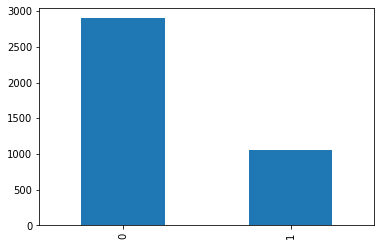

In [ ]:
train_data['Insult'].value_counts().plot(kind='bar')

In [ ]:
def myTokenizer(x):
 return  [snowstem.stem(word.text)for word in 
          tokenizer(removepunc(re.sub(r"\s+\s+"," ",re.sub(r"[^A-Za-z0-9()!?\'\`\"\r+\n+]"," ",x.lower()))).strip()) 
          if (word.text not in stops and not hasNumbers(word.text)) ]

In [ ]:
TEXT = data.Field(tokenize=myTokenizer,batch_first=True,fix_length=140)
LABEL = data.LabelField(dtype=torch.float ,batch_first=True)
class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('Comment', text_field), ('Insult', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.Insult 
            text = row.Comment
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)
  

torchdataset = DataFrameDataset(train_data, TEXT,LABEL)
torchtest = DataFrameDataset(test_data, TEXT,LABEL)
train_data, valid_data = torchdataset.split(split_ratio=0.9, random_state = random.seed(SEED))

In [ ]:
TEXT.build_vocab(train_data)  
LABEL.build_vocab(train_data)

In [ ]:
TEXT.build_vocab(train_data)  
LABEL.build_vocab(train_data)
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(15)) 

Size of TEXT vocabulary: 10534
Size of LABEL vocabulary: 2
[('n', 1428), ('like', 687), ('get', 453), ('dont', 421), ('fuck', 407), ('go', 379), ('peopl', 371), ('one', 342), ('would', 330), ('know', 320), ('think', 316), ('make', 276), (' ', 253), ('say', 252), ('time', 251)]


In [ ]:
#set batch size
BATCH_SIZE = 128

"""
we are using batches for validation and test set because of memory usage we can't pass the whole set at once 
"""


train_iterator,valid_iterator,test_iterator= data.BucketIterator.splits(
    (train_data,valid_data,torchtest), 
    batch_size = BATCH_SIZE,
    device = device,
    sort =False,
shuffle=False)


In [ ]:
class TextTransformer(nn.Module):
  def __init__(self):
    super(TextTransformer,self).__init__()
    self.wordEmbeddings = nn.Embedding(len(TEXT.vocab),140)
    self.positionEmbeddings = nn.Embedding(140,20)
    self.transformerLayer = nn.TransformerEncoderLayer(160,8) 
    self.linear1 = nn.Linear(160,  64)
    self.linear2 = nn.Linear(64,  1)
    self.linear3 = nn.Linear(140,  16)
    self.linear4 = nn.Linear(16,  1)
  def forward(self,x):
    positions = (torch.arange(0,140).reshape(1,140) + torch.zeros(x.shape[0],140)).to(device) 
    # broadcasting the tensor of positions 
    sentence = torch.cat((self.wordEmbeddings(x.long()),self.positionEmbeddings(positions.long())),axis=2)
    attended = self.transformerLayer(sentence)
    linear1 = F.relu(self.linear1(attended))
    linear2 = F.relu(self.linear2(linear1))
    linear2 = linear2.view(-1,140) # reshaping the layer as the transformer outputs a 2d tensor (or 3d considering the batch size)
    linear3 = F.relu(self.linear3(linear2))
    out = torch.sigmoid(self.linear4(linear3))
    return out

myTransformer = TextTransformer()
myTransformer.to(device)


TextTransformer(
  (wordEmbeddings): Embedding(10534, 140)
  (positionEmbeddings): Embedding(140, 20)
  (transformerLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=160, out_features=160, bias=True)
    )
    (linear1): Linear(in_features=160, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=160, bias=True)
    (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear1): Linear(in_features=160, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (linear3): Linear(in_features=140, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
def calculateMetrics(ypred,ytrue):
  acc  = accuracy_score(ytrue,ypred)
  f1  = f1_score(ytrue,ypred)
  f1_average  = f1_score(ytrue,ypred,average="macro")
  return " f1 score: "+str(round(f1,3))+" f1 average: "+str(round(f1_average,3))+" accuracy: "+str(round(acc,3))

In [ ]:

optimizer = optim.Adam(myTransformer.parameters(),lr = 0.001)

for i in range(20):
  trainpreds = torch.tensor([])
  traintrues = torch.tensor([])
  for  batch in train_iterator:
    X = batch.Comment
    y = batch.Insult
    myTransformer.zero_grad()
    pred = myTransformer(X).squeeze()
    trainpreds = torch.cat((trainpreds,pred.cpu().detach()))
    traintrues = torch.cat((traintrues,y.cpu().detach()))
    err = F.binary_cross_entropy(pred,y)
    err.backward()
    optimizer.step()
  err = F.binary_cross_entropy(trainpreds,traintrues)
  print("train BCE loss: ",err.item(),calculateMetrics(torch.round(trainpreds).numpy(),traintrues.numpy()))
 

  valpreds = torch.tensor([])
  valtrues = torch.tensor([])
  for batch in valid_iterator:
    X = batch.Comment
    y = batch.Insult
    valtrues = torch.cat((valtrues,y.cpu().detach()))
    pred = myTransformer(X).squeeze().cpu().detach()
    # print(valtrues.shape)
    valpreds = torch.cat((valpreds,pred))
  err = F.binary_cross_entropy(valpreds,valtrues)
  print("validation BCE loss: ",err.item(),calculateMetrics(torch.round(valpreds).numpy(),valtrues.numpy()))
  

train BCE loss:  0.6610249280929565  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.6509506106376648  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6474252939224243  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.636728048324585  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6342032551765442  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.6223083734512329  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6212819218635559  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.6087058186531067  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6096282005310059  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5964187979698181  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.5996088981628418  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.586143434047699  

In [ ]:

optimizer = optim.Adagrad(myTransformer.parameters(),lr = 0.001)

for i in range(20):
  trainpreds = torch.tensor([])
  traintrues = torch.tensor([])
  for  batch in train_iterator:
    X = batch.Comment
    y = batch.Insult
    myTransformer.zero_grad()
    pred = myTransformer(X).squeeze()
    trainpreds = torch.cat((trainpreds,pred.cpu().detach()))
    traintrues = torch.cat((traintrues,y.cpu().detach()))
    err = F.binary_cross_entropy(pred,y)
    err.backward()
    optimizer.step()
  err = F.binary_cross_entropy(trainpreds,traintrues)
  print("train BCE loss: ",err.item(),calculateMetrics(torch.round(trainpreds).numpy(),traintrues.numpy()))
 

  valpreds = torch.tensor([])
  valtrues = torch.tensor([])
  for batch in valid_iterator:
    X = batch.Comment
    y = batch.Insult
    valtrues = torch.cat((valtrues,y.cpu().detach()))
    pred = myTransformer(X).squeeze().cpu().detach()
    # print(valtrues.shape)
    valpreds = torch.cat((valpreds,pred))
  err = F.binary_cross_entropy(valpreds,valtrues)
  print("validation BCE loss: ",err.item(),calculateMetrics(torch.round(valpreds).numpy(),valtrues.numpy()))
  

train BCE loss:  0.5804764628410339  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5661464333534241  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.5804509520530701  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5661569833755493  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.5804464221000671  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5661646127700806  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.5804438591003418  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5661706328392029  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.5804420709609985  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5661754608154297  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.5804407000541687  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.5661795735359192

In [ ]:
"""
now getting the results on the test set
"""

testpreds = torch.tensor([])
testtrues = torch.tensor([])
for batch in test_iterator:
    X = batch.Comment
    y = batch.Insult
    testtrues = torch.cat((testtrues,y.cpu().detach()))
    pred = myTransformer(X).squeeze().cpu().detach()
    # print(valtrues.shape)
    testpreds = torch.cat((testpreds,pred))
err = F.binary_cross_entropy(testpreds,testtrues)
print("test BCE loss: ",err.item(),calculateMetrics(torch.round(testpreds).numpy(),testtrues.numpy()))

test BCE loss:  0.5749812126159668  f1 score: 0.0 f1 average: 0.425 accuracy: 0.738


In [ ]:
test_data["predicted"] = torch.round(testpreds).numpy()


"""
this shows that the model understands the language well 

"""

test_data[test_data.predicted==0].iloc[1:5]

,Insult,Comment,predicted
1,0,"""@ian21\xa0""Roger Clemens is the fucking man, ...",0.0
2,1,"""Agree with Alan you are an extremest idiot. ...",0.0
3,0,"""Really?\\n\\nI see Marc Lamont Hill on variou...",0.0
4,0,"""Really suck isn't the word, when many of our ...",0.0


Dealing With Imbalanced Data set using Undersampling of the majority class

In [ ]:
#CODE TO Undersample
#u = train_data.columns[:]

##Class_count
count_class_0, count_class_1 = train_data.Insult.value_counts()

##Divide by Class
df_class_0 = train_data[train_data ['Insult']==0]
df_class_1 = train_data[train_data ['Insult']==1]

##Oversampling of Imbalance_class
df_class_0_over = df_class_0.sample(count_class_1, replace =True)
df_class_merge = pd.concat([df_class_1, df_class_0_over], axis=0)
df_class_merge.Insult.value_counts()


1    1049
0    1049
Name: Insult, dtype: int64

In [ ]:
def myTokenizer(x):
 return  [snowstem.stem(word.text)for word in 
          tokenizer(removepunc(re.sub(r"\s+\s+"," ",re.sub(r"[^A-Za-z0-9()!?\'\`\"\r+\n+]"," ",x.lower()))).strip()) 
          if (word.text not in stops and not hasNumbers(word.text)) ]

In [ ]:
TEXT = data.Field(tokenize=myTokenizer,batch_first=True,fix_length=140)
LABEL = data.LabelField(dtype=torch.float ,batch_first=True)
class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('Comment', text_field), ('Insult', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.Insult 
            text = row.Comment
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)
  

torchdataset = DataFrameDataset(train_data, TEXT,LABEL)
torchtest = DataFrameDataset(test_data, TEXT,LABEL)
train_data, valid_data = torchdataset.split(split_ratio=0.9, random_state = random.seed(SEED))

In [ ]:
TEXT.build_vocab(train_data)  
LABEL.build_vocab(train_data)
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(15)) 

Size of TEXT vocabulary: 10534
Size of LABEL vocabulary: 2
[('n', 1428), ('like', 687), ('get', 453), ('dont', 421), ('fuck', 407), ('go', 379), ('peopl', 371), ('one', 342), ('would', 330), ('know', 320), ('think', 316), ('make', 276), (' ', 253), ('say', 252), ('time', 251)]


In [ ]:
#set batch size
BATCH_SIZE = 128

"""
we are using batches for validation and test set because of memory usage we can't pass the whole set at once 
"""


train_iterator,valid_iterator,test_iterator= data.BucketIterator.splits(
    (train_data,valid_data,torchtest), 
    batch_size = BATCH_SIZE,
    device = device,
    sort =False,
shuffle=False)


In [ ]:
class TextTransformer(nn.Module):
  def __init__(self):
    super(TextTransformer,self).__init__()
    self.wordEmbeddings = nn.Embedding(len(TEXT.vocab),140)
    self.positionEmbeddings = nn.Embedding(140,20)
    self.transformerLayer = nn.TransformerEncoderLayer(160,8) 
    self.linear1 = nn.Linear(160,  64)
    self.linear2 = nn.Linear(64,  1)
    self.linear3 = nn.Linear(140,  16)
    self.linear4 = nn.Linear(16,  1)
  def forward(self,x):
    positions = (torch.arange(0,140).reshape(1,140) + torch.zeros(x.shape[0],140)).to(device) 
    # broadcasting the tensor of positions 
    sentence = torch.cat((self.wordEmbeddings(x.long()),self.positionEmbeddings(positions.long())),axis=2)
    attended = self.transformerLayer(sentence)
    linear1 = F.relu(self.linear1(attended))
    linear2 = F.relu(self.linear2(linear1))
    linear2 = linear2.view(-1,140) # reshaping the layer as the transformer outputs a 2d tensor (or 3d considering the batch size)
    linear3 = F.relu(self.linear3(linear2))
    out = torch.sigmoid(self.linear4(linear3))
    return out

myTransformer = TextTransformer()
myTransformer.to(device)


TextTransformer(
  (wordEmbeddings): Embedding(10534, 140)
  (positionEmbeddings): Embedding(140, 20)
  (transformerLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=160, out_features=160, bias=True)
    )
    (linear1): Linear(in_features=160, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=160, bias=True)
    (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear1): Linear(in_features=160, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (linear3): Linear(in_features=140, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
def calculateMetrics(ypred,ytrue):
  acc  = accuracy_score(ytrue,ypred)
  f1  = f1_score(ytrue,ypred)
  f1_average  = f1_score(ytrue,ypred,average="macro")
  return " f1 score: "+str(round(f1,3))+" f1 average: "+str(round(f1_average,3))+" accuracy: "+str(round(acc,3))

In [ ]:

optimizer = optim.Adam(myTransformer.parameters(),lr = 0.001)

for i in range(20):
  trainpreds = torch.tensor([])
  traintrues = torch.tensor([])
  for  batch in train_iterator:
    X = batch.Comment
    y = batch.Insult
    myTransformer.zero_grad()
    pred = myTransformer(X).squeeze()
    trainpreds = torch.cat((trainpreds,pred.cpu().detach()))
    traintrues = torch.cat((traintrues,y.cpu().detach()))
    err = F.binary_cross_entropy(pred,y)
    err.backward()
    optimizer.step()
  err = F.binary_cross_entropy(trainpreds,traintrues)
  print("train BCE loss: ",err.item(),calculateMetrics(torch.round(trainpreds).numpy(),traintrues.numpy()))
 

  valpreds = torch.tensor([])
  valtrues = torch.tensor([])
  for batch in valid_iterator:
    X = batch.Comment
    y = batch.Insult
    valtrues = torch.cat((valtrues,y.cpu().detach()))
    pred = myTransformer(X).squeeze().cpu().detach()
    # print(valtrues.shape)
    valpreds = torch.cat((valpreds,pred))
  err = F.binary_cross_entropy(valpreds,valtrues)
  print("validation BCE loss: ",err.item(),calculateMetrics(torch.round(valpreds).numpy(),valtrues.numpy()))
  

train BCE loss:  0.7048015594482422  f1 score: 0.422 f1 average: 0.211 accuracy: 0.267
validation BCE loss:  0.6966125965118408  f1 score: 0.404 f1 average: 0.202 accuracy: 0.253
train BCE loss:  0.6902215480804443  f1 score: 0.248 f1 average: 0.492 accuracy: 0.61
validation BCE loss:  0.6829929947853088  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6773678660392761  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.668710470199585  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6634654402732849  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.6533322930335999  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6489499807357788  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.6376236081123352  f1 score: 0.0 f1 average: 0.428 accuracy: 0.747
train BCE loss:  0.6346308588981628  f1 score: 0.0 f1 average: 0.423 accuracy: 0.733
validation BCE loss:  0.622464120388

In [ ]:
"""
now getting the results on the test set
"""

testpreds = torch.tensor([])
testtrues = torch.tensor([])
for batch in test_iterator:
    X = batch.Comment
    y = batch.Insult
    testtrues = torch.cat((testtrues,y.cpu().detach()))
    pred = myTransformer(X).squeeze().cpu().detach()
    # print(valtrues.shape)
    testpreds = torch.cat((testpreds,pred))
err = F.binary_cross_entropy(testpreds,testtrues)
print("test BCE loss: ",err.item(),calculateMetrics(torch.round(testpreds).numpy(),testtrues.numpy()))

test BCE loss:  1.1869328022003174  f1 score: 0.42 f1 average: 0.6 accuracy: 0.681


In [ ]:
test_data["predicted"] = torch.round(testpreds).numpy()


"""
this shows that the model understands the language well 

"""

test_data[test_data.predicted==1].iloc[1:10]

,Insult,Comment,predicted
4,0,"""Really suck isn't the word, when many of our ...",1.0
6,0,"""Matthews mentored Perry at USC. Bodes well...""",1.0
7,0,"""How about we accept facts and patiently wait ...",1.0
20,0,"""I\\'m a second generation German working on m...",1.0
23,1,"""GO SUCK_YOU DADDYS_COCK_OBAMA LOVING LIBERAL_...",1.0
24,0,"""yeah!!!! fuck undying!""",1.0
27,1,"""i live with my dad asshole!!! i anal fuked th...",1.0
30,1,"""Hey race baiter take a hike you are a typical...",1.0
37,1,"""go away you trashy\xa0 tramp""",1.0
